In [124]:
import os
import warnings

warnings.filterwarnings('ignore')

import sys
sys.path.append('../')
sys.path.append('../../')

In [125]:
print(os.listdir("../results/samples"))

train_path = "../results/samples/train/"
valid_path = "../results/samples/validation/"
test_path = "../results/samples/test/"

['train', 'validation', 'test']


In [126]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from Mask_RCNN.mrcnn.utils import Dataset

import numpy as np
 
# class that defines and loads the dataset
# Dataset is a parent!!!
class GetDataset(Dataset):
    
    # load the dataset definitions
    def load_dataset(self, dataset_name, pathname, num_of_images = -1):
        
        # 1 == the number of classes (not including background), 
        # dataset_name is to help keep track of what the instance of the
        # class is holding. In this case it's "sand_dollar"
        self.add_class('dataset', 1, 'sand dollar')
        
        # Goes through all of the folder, records the basename of each file
        # then knowing that each the filenames are the same, just concats the suffix
        # to the basename, then appends each to their respective arrays
        
        # !!! Change to use glob instead of os !!!
        
        count = 0
        
        for file in os.listdir(pathname):
            
            # makes it so that we only loop through once and twice (i.e. creating duplicates)
            if(".orig.xml" in file):

                filename = file.split(".orig")[0]
                image_ids = filename

                xml_path = pathname + filename + ".orig.xml"

                image_path = pathname + filename + ".orig.jpg"
                
                self.add_image('dataset', image_id = image_ids, path = image_path, annotation = xml_path) 
                
                count += 1
                
                if(count == num_of_images):
                    break
            
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        
        # get the root of the document
        root = tree.getroot()
        
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        return boxes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        
        # get details of image
        info = self.image_info[image_id]
        
        # define box file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
        
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('sand dollar'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [127]:
# train set
train_set = GetDataset()
train_set.load_dataset('sand dollar train', train_path, num_of_images = 206)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# val set
val_set = GetDataset()
val_set.load_dataset('sand dollar validation', valid_path)
val_set.prepare()
print('Valid: %d' % len(val_set.image_ids))

# test set
test_set = GetDataset()
test_set.load_dataset('sand dollar test', test_path)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 206
Valid: 20
Test: 61


(1024, 1360, 3)
(1024, 1360, 182)


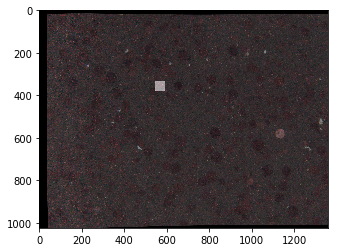

In [128]:
# Just a display of a image and a annotation
import matplotlib.pyplot as plt

index = np.random.randint(len(train_set.image_ids))

image = train_set.load_image(index)
print(image.shape)

# load image mask
mask, class_ids = train_set.load_mask(index)
print(mask.shape)

# plot image
plt.imshow(image)

# plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()

In [129]:
# Gives a view of what's going on in the object we created
def sanity_check(dataset):
    for image_id in dataset.image_ids:
        # load image info
        info = dataset.image_info[image_id]
        # display on the console
        print(info)
        
#sanity_check(train_set)

../results/samples/train/201503.20150602.115739880.62278.orig.jpg
Number of annotations: 1


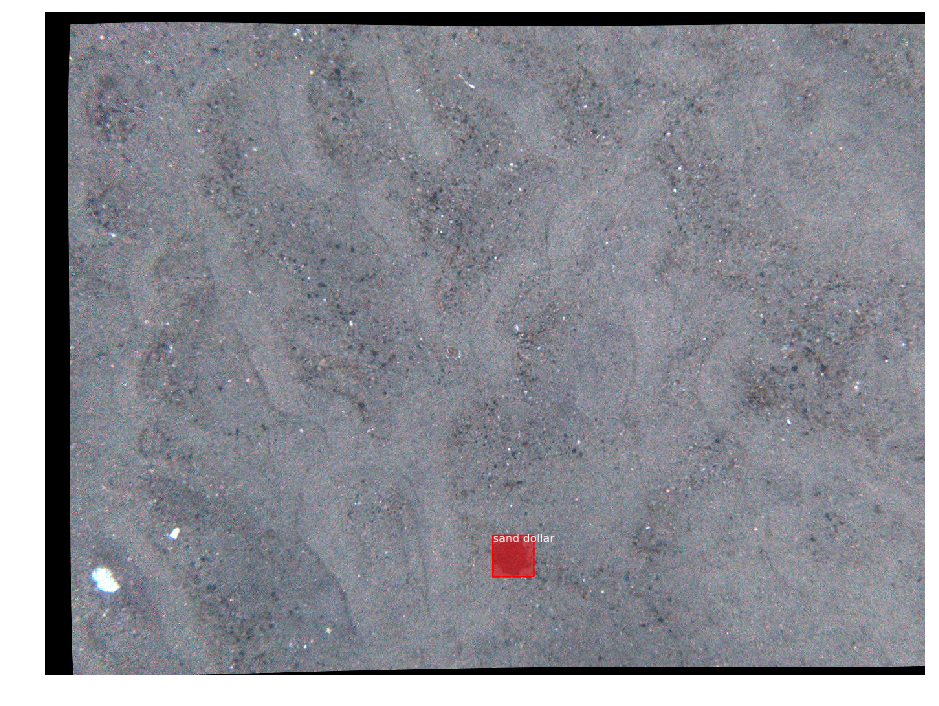

In [130]:
# Provides a better display of a image, and ALL of the annotations for said image
# takes a bit of time, blame the original repo, but at least it's pretty :)

from Mask_RCNN.mrcnn.visualize import display_instances
from Mask_RCNN.mrcnn.utils import extract_bboxes
# in visualize.py, change line 28 to "from Mask_RCNN.mrcnn import utils" :)

# define image id
index = 5

print(train_set.image_reference(index))

# load the image
image = train_set.load_image(index)

# load the masks and the class ids
mask, class_ids = train_set.load_mask(index)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)

print("Number of annotations:", mask.shape[2])
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [131]:
from Mask_RCNN.mrcnn.config import Config

# define a configuration for the training process
# can change the configure file, see the original
# MaskRCNN repo for details about different hyperparameters!

# Will need everyone's help figuring out the hyperparameters!
class TrainConfig(Config):
   
    # define the name of the configuration
    NAME = "sand_dollar_config"
    
    IMAGES_PER_GPU = 1
    
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    
    # number of training steps per epoch
    STEPS_PER_EPOCH = len(train_set.image_ids)
    
    LEARNING_RATE = .0001    
    
    WEIGHT_DECAY = 0.00001
    
    IMAGE_MAX_DIM = 256
    
    IMAGE_MIN_DIM = 256
    
training_config = TrainConfig()

In [132]:
from Mask_RCNN.mrcnn.model import MaskRCNN
# Change line 29 in model.py to "from Mask_RCNN.mrcnn import utils"

training_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

image_id:  ../results/samples/train/201503.20150602.115739880.62278.orig.jpg
Original shape:  (1024, 1360, 3)
New shape: (256, 256, 3)


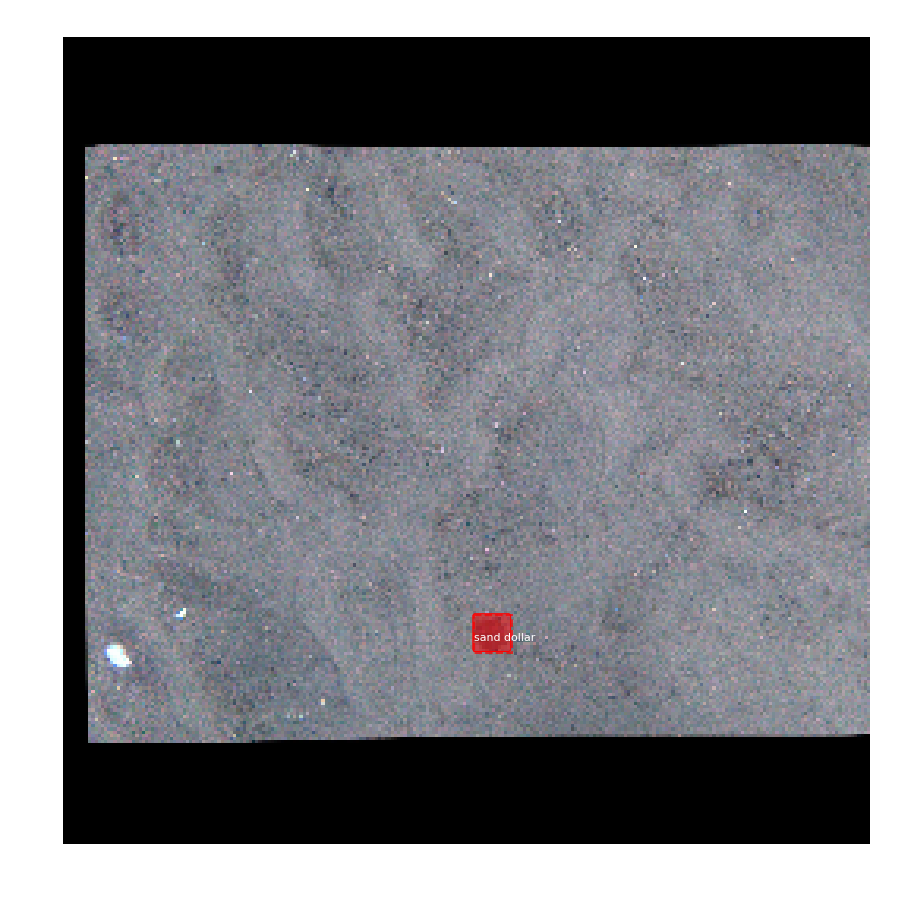

In [133]:
# Resizing training images and mask based on the details in the config file
from Mask_RCNN.mrcnn import utils, visualize

image = train_set.load_image(index)
mask, class_ids = train_set.load_mask(index)
original_shape = image.shape

# Resize
image, window, scale, padding, crop = utils.resize_image(image, min_dim=training_config.IMAGE_MIN_DIM, max_dim=training_config.IMAGE_MAX_DIM)

mask = utils.resize_mask(mask, scale, padding)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)


# Display image and additional stats
print("image_id: ", train_set.image_reference(index))
print("Original shape: ", original_shape)
print("New shape:", image.shape)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [134]:
# define the model
model = MaskRCNN(mode='training', model_dir='./eventlogs', config=training_config)
!pwd

# load weights (mscoco) and exclude the output layers
model.load_weights('../Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

'''
# train weights (output layers or 'heads')
model.train(train_set, val_set, learning_rate=training_config.LEARNING_RATE, epochs = 5, layers='heads')
'''

/home/coral/Oceanhackweek2019/OHW2019-CV_Project/ohw19-project-computer_vision_club


"\n# train weights (output layers or 'heads')\nmodel.train(train_set, val_set, learning_rate=training_config.LEARNING_RATE, epochs = 5, layers='heads')\n"

In [135]:
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

from Mask_RCNN.mrcnn.utils import compute_ap
from Mask_RCNN.mrcnn.model import load_image_gt
from Mask_RCNN.mrcnn.model import mold_image

# define the prediction configuration, very similar to the train config as above
class TestConfig(Config):
    # define the name of the configuration
    NAME = "sand_dollar_config"
    
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MAX_DIM = 256
    
    IMAGE_MIN_DIM = 256
    
    #### Add IMG_MIN MAX here (add changes in configuration from traing here)
 


In [136]:
testing_config = TestConfig()

testing_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [137]:
# calculate the mAP for a model on a given dataset 
# (taken directly from kangaroo tutorial)
def evaluate_model(dataset, model, cfg, filename):
    APs = list()
    for image_id in dataset.image_ids:
        
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        
        # convert pixel values (e.g. center)
        # essentially preprocessing the images to match
        # the format the images were when we used them
        # for training
        scaled_image = mold_image(image, cfg)
        
        # convert image into one sample
        # changes the dimensions to include the 
        # number of batches (which is one)
        sample = expand_dims(scaled_image, 0)
       
        # make prediction
        yhat = model.detect(sample, verbose=0)
        
        # extract results for first sample
        r = yhat[0]
        
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        
        # store
        APs.append(AP)
    
    # calculate the mean AP across all images
    mAP = mean(APs)

    fig = plt.figure()
    APs = np.array(APs)
    plt.hist(APs, density = True)
    plt.title('mAP:' + str(round(mAP,3)))
    plt.ylim((0,2.5))
    plt.ylabel('Absolute Precision')
    fig.savefig(filename)
    
    return mAP

Re-starting from epoch 5
Train mAP: 0.234
Test mAP: 0.245


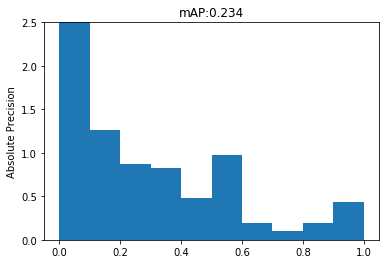

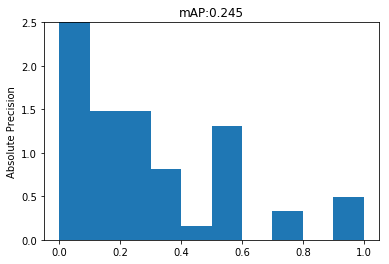

In [138]:
model = MaskRCNN(mode = 'inference', model_dir = './eventlogs/', config = testing_config)

# load model weights that did the best (see the model training output and the epoch with the lowest validation loss scores).

# the weights save in a folder in the eventlogs so that needs to be manually typed in (different for each person)
model.load_weights('./eventlogs/sand_dollar_config20190829T2350/mask_rcnn_sand_dollar_config_0005.h5', by_name = True)

# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, testing_config, 'training_mAP.png')
print("Train mAP: %.3f" % train_mAP)

# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, testing_config, 'testing_mAP.png')
print("Test mAP: %.3f" % test_mAP)

In [139]:
'''
import pandas as pd
from skimage import io
import matplotlib.patches as patches

def convert_xml_file(xml_file):
    xml_list = []
    tree = ElementTree.parse(xml_file)
    root = tree.getroot()
    
    for member in root.findall('object'):
        value = (root.find('filename').text,
                 int(root.find('size')[0].text),
                 int(root.find('size')[1].text),
                 member[0].text,
                 int(member[4][0].text),
                 int(member[4][1].text),
                 int(member[4][2].text),
                 int(member[4][3].text)
                 )
        xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    
    return xml_df

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images = 5):
    
    plt.figure(figsize = (20, 20))
    # load image and mask
    for i in range(n_images):
        
        # load the image and mask
        img_path = train_set.image_info[i]['path'] 
        image = io.imread(img_path)
        
        scaled_image = mold_image(image, cfg)
 
        sample = expand_dims(scaled_image, 0)
        
        xml_path = train_set.image_info[i]['annotation']
        annotations = convert_xml_file(xml_path)
        
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        
        # plot raw pixel data
        plt.imshow(image)
        plt.title("Actual number of sand dollars: " + str(len(annotations)))
        ax = plt.gca()
        
        for index, row in annotations.iterrows():
            # get coordinates
            y1, x1, y2, x2 = row['ymin'], row['xmin'], row['ymax'], row['xmax']
            
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            
            # create the shape
            rect = patches.Rectangle((x1, y1), width, height, fill = False, color = 'yellow')
            
            # draw the box
            ax.add_patch(rect)
        
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)

        
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        
        # plot raw pixel data
        plt.imshow(image)
        plt.title("Predicted number of sand dollars: " + str(len(yhat['rois'])))
        ax = plt.gca()
        
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            
            # create the shape
            rect = patches.Rectangle((x1, y1), width, height, fill = False, color='green')
            
            # draw the box
            ax.add_patch(rect)
    
    plt.savefig("Corals_results", dpi = 300)
'''

'\nimport pandas as pd\nfrom skimage import io\nimport matplotlib.patches as patches\n\ndef convert_xml_file(xml_file):\n    xml_list = []\n    tree = ElementTree.parse(xml_file)\n    root = tree.getroot()\n    \n    for member in root.findall(\'object\'):\n        value = (root.find(\'filename\').text,\n                 int(root.find(\'size\')[0].text),\n                 int(root.find(\'size\')[1].text),\n                 member[0].text,\n                 int(member[4][0].text),\n                 int(member[4][1].text),\n                 int(member[4][2].text),\n                 int(member[4][3].text)\n                 )\n        xml_list.append(value)\n    column_name = [\'filename\', \'width\', \'height\', \'class\', \'xmin\', \'ymin\', \'xmax\', \'ymax\']\n    xml_df = pd.DataFrame(xml_list, columns=column_name)\n    \n    return xml_df\n\n# plot a number of photos with ground truth and predictions\ndef plot_actual_vs_predicted(dataset, model, cfg, n_images = 5):\n    \n    plt.fig

In [140]:
import pandas as pd
from skimage import io
import matplotlib.patches as patches

def convert_xml_file(xml_file):
    xml_list = []
    tree = ElementTree.parse(xml_file)
    root = tree.getroot()
    
    for member in root.findall('object'):
        value = (root.find('filename').text,
                 int(root.find('size')[0].text),
                 int(root.find('size')[1].text),
                 member[0].text,
                 int(member[4][0].text),
                 int(member[4][1].text),
                 int(member[4][2].text),
                 int(member[4][3].text)
                 )
        xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    
    return xml_df

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images = 5):
    
    for i in range(n_images):
        
        index = np.random.randint(dataset.num_images)
        plt.figure(figsize = (30, 30))
        
        # load the image and mask
        img_path = dataset.image_info[index]['path'] 
        image = io.imread(img_path)
        
        scaled_image = mold_image(image, cfg)
 
        sample = expand_dims(scaled_image, 0)
        
        xml_path = dataset.image_info[index]['annotation']
        annotations = convert_xml_file(xml_path)
        
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        
        # plot raw pixel data
        plt.imshow(image)
        plt.title("Actual number of sand dollars: " + str(len(annotations)), fontsize = 30)
        plt.axis('off')
        ax = plt.gca()
        
        for index, row in annotations.iterrows():
            # get coordinates
            y1, x1, y2, x2 = row['ymin'], row['xmin'], row['ymax'], row['xmax']
            
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            
            # create the shape
            rect = patches.Rectangle((x1, y1), width, height, fill = False, color = 'yellow')
            
            # draw the box
            ax.add_patch(rect)
        
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)

        
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        
        # plot raw pixel data
        plt.imshow(image)
        plt.title("Predicted number of sand dollars: " + str(len(yhat['rois'])), fontsize = 30)
        plt.axis('off')
        ax = plt.gca()
        
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            
            # create the shape
            rect = patches.Rectangle((x1, y1), width, height, fill = False, color='aqua')
            
            # draw the box
            ax.add_patch(rect)
    
    plt.savefig("Corals_results", dpi = 150)
    plt.show()

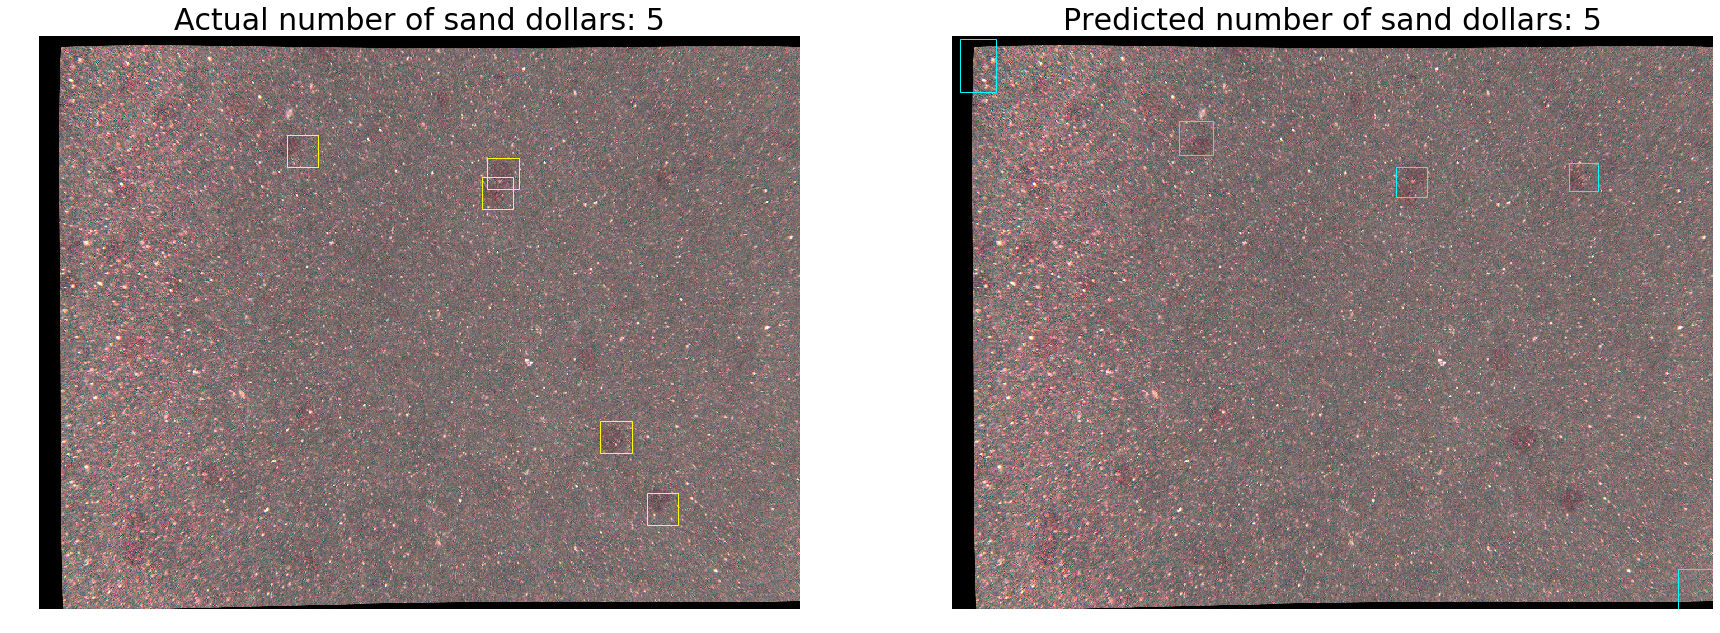

In [141]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, testing_config, n_images = 1)

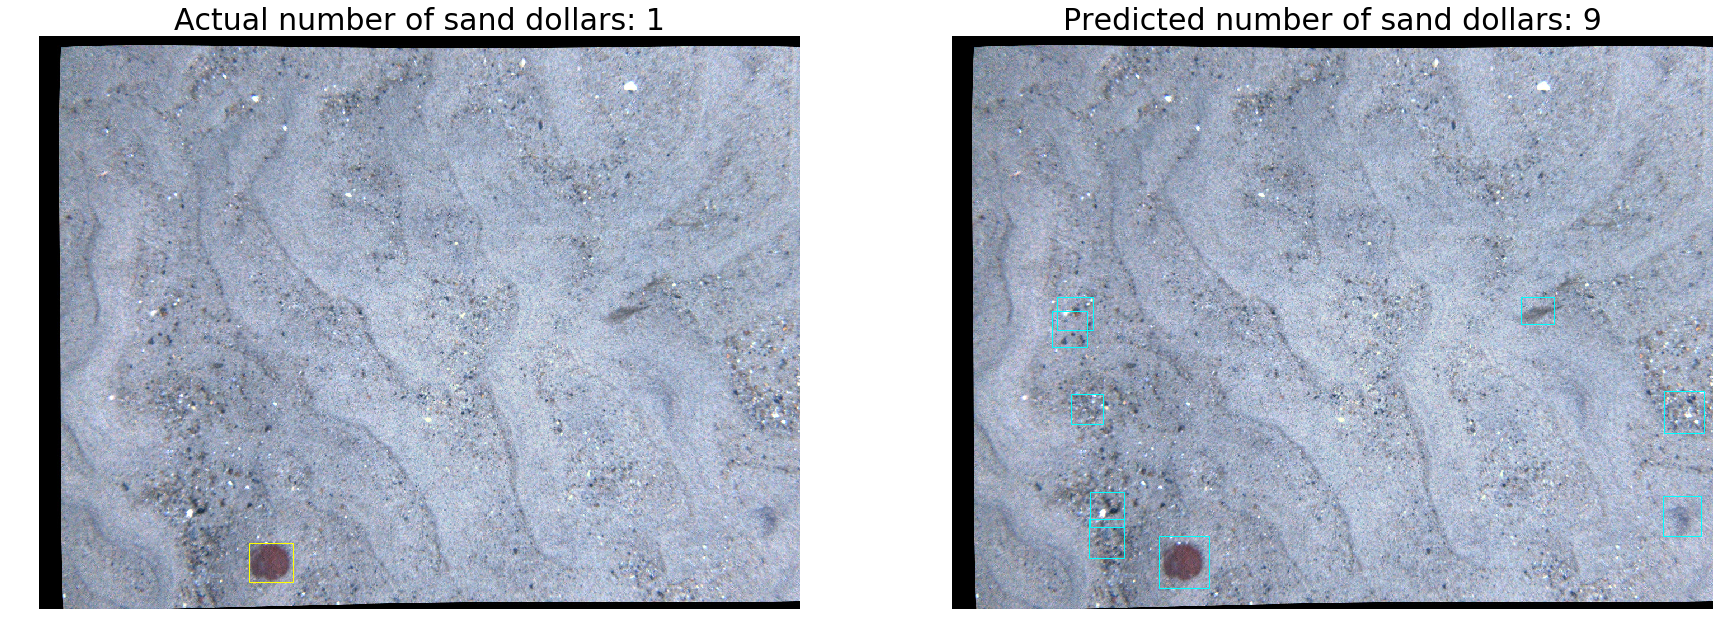

In [142]:
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, testing_config, n_images = 1)

In [59]:
!gist ./html/cv_image_size_512.html

Please log in with `gist --login`. (Github now requires credentials to gist https://bit.ly/2GBBxKw)
